# Import libraries

In [34]:
import pandas as pd
from lifetimes.utils import summary_data_from_transaction_data
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt


# Define Function

In [35]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

def viz_categorical_summarized(data, x=None, y=None, hue=None, hue_order = None, palette='PuBuGn_d', ax=None, order=None, verbose=False, stacked = False, annotate = False):
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = data[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())
        
    if (stacked == True and hue != None):
        if x == None:
            x = y
            temp = data.groupby([hue, x]).size().reset_index().pivot(columns=hue, index=y, values=0)
            temp.plot(kind='barh', stacked=True)
        elif y == None:
            temp = data.groupby([hue, x]).size().reset_index().pivot(columns=hue, index=x, values=0)
            temp.plot(kind='bar', stacked=True)
        plt.gcf()
    else:
        ax = sns.countplot(x=x, y=y, hue=hue, data=data,
                  palette=palette, order=order, ax=ax, hue_order = hue_order)
        if annotate:
            for p in ax.patches:
                ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        
        plt.show()

# Import data and data cleansing

In [36]:
df = pd.read_csv('data/data.csv', encoding = "ISO-8859-1")

In [37]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


- Remove negative quantity invoice
- Remove Outlier / Abnormal invoice quantity (Set: > 10000 units)
- Remove invalid customer ID

In [38]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"]).dt.date
df.query("Quantity > 0", inplace = True)
df.query("Quantity <= 10000", inplace = True)
df['Sales'] = df['Quantity'] * df['UnitPrice']
df = df[pd.notnull(df["CustomerID"])]

# Transform invoice data as RFM schema

In [39]:
df_rfm = summary_data_from_transaction_data(df, customer_id_col = "CustomerID", datetime_col = "InvoiceDate", monetary_value_col="Sales")

In [40]:
df_rfm

,frequency,recency,T,monetary_value
CustomerID,,,,
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000
12352.0,6.0,260.0,296.0,368.256667
...,...,...,...,...
18280.0,0.0,0.0,277.0,0.000000
18281.0,0.0,0.0,180.0,0.000000
18282.0,1.0,119.0,126.0,77.840000


# Find the optimal n_cluster of each column by K-means clustering with Silhouette Score

In [41]:
cluster_result = pd.DataFrame()
cluster_range = [3,4,5,6,7,8,9,10]
cluster_result['Cluster'] = pd.Series(cluster_range) 
for metric in ['frequency', 'recency', 'monetary_value']:
    print ("-"*15 + metric + "-"*15)
    temp_result = []
    for n_cluster in cluster_range:
        kmeans = KMeans(n_clusters=n_cluster).fit(
            df_rfm[[metric]]
        )
        silhouette_avg = silhouette_score(
            df_rfm[[metric]], 
            kmeans.labels_
        )
        temp_result.append(silhouette_avg)
        print('Silhouette Score for %i Clusters: %0.4f' % (n_cluster, silhouette_avg))
    cluster_result[metric] = pd.Series(temp_result)
cluster_result.set_index('Cluster', inplace=True)

---------------frequency---------------
Silhouette Score for 3 Clusters: 0.8000
Silhouette Score for 4 Clusters: 0.7024
Silhouette Score for 5 Clusters: 0.6864
Silhouette Score for 6 Clusters: 0.6773
Silhouette Score for 7 Clusters: 0.6643
Silhouette Score for 8 Clusters: 0.6755
Silhouette Score for 9 Clusters: 0.6927
Silhouette Score for 10 Clusters: 0.7507
---------------recency---------------
Silhouette Score for 3 Clusters: 0.7097
Silhouette Score for 4 Clusters: 0.7044
Silhouette Score for 5 Clusters: 0.7074
Silhouette Score for 6 Clusters: 0.7101
Silhouette Score for 7 Clusters: 0.7063
Silhouette Score for 8 Clusters: 0.7069
Silhouette Score for 9 Clusters: 0.7065
Silhouette Score for 10 Clusters: 0.7102
---------------monetary_value---------------
Silhouette Score for 3 Clusters: 0.7518
Silhouette Score for 4 Clusters: 0.6977
Silhouette Score for 5 Clusters: 0.6224
Silhouette Score for 6 Clusters: 0.6462
Silhouette Score for 7 Clusters: 0.6488
Silhouette Score for 8 Clusters: 0.

In [42]:
cluster_result

,frequency,recency,monetary_value
Cluster,,,
3,0.799969,0.709719,0.751838
4,0.702379,0.704352,0.697719
5,0.686377,0.707449,0.622375
6,0.677317,0.710125,0.646152
7,0.664334,0.706333,0.648844
8,0.675536,0.706895,0.656744
9,0.692685,0.706530,0.686194
10,0.750714,0.710204,0.695651


In [43]:
final_cluster_result = pd.DataFrame()

for metric in ['frequency', 'recency', 'monetary_value']:
    best_cluster = cluster_result[metric].idxmax()
    final_cluster_result = final_cluster_result.append({'Column': metric, 'Cluster': best_cluster}, ignore_index = True)

    
# For visualisation usage, the cluster will follow the order of value like --> monetary greater, cluster greater
greater_is_better_columns = ['frequency', 'monetary_value']
final_cluster_result['greater_is_better'] = final_cluster_result['Column'].isin(greater_is_better_columns)

In [44]:
final_cluster_result

,Cluster,Column,greater_is_better
0,3.0,frequency,True
1,10.0,recency,False
2,3.0,monetary_value,True


# Customer Segmentation

In [45]:
for metric in ['frequency', 'recency', 'monetary_value']:
#     print (int(final_cluster_result[final_cluster_result['Column'] == metric]['Cluster'].iloc[0]))
    kmeans = KMeans(n_clusters=int(final_cluster_result.loc[final_cluster_result['Column'] == metric]['Cluster'].iloc[0]))
    kmeans.fit(df_rfm[[metric]])
    df_rfm[f'{metric}Cluster'] = kmeans.predict(df_rfm[[metric]])

    #order the TotalSales cluster (Higher is better)
    df_rfm = order_cluster(f'{metric}Cluster', metric, df_rfm, final_cluster_result.loc[final_cluster_result['Column'] == metric]['greater_is_better'].iloc[0])

# calculate overall score and use mean() to see details
df_rfm["OverallScore"] = (
    df_rfm["frequencyCluster"]
    + df_rfm["recencyCluster"]
    + df_rfm["monetary_valueCluster"]
)

In [46]:
df_rfm["frequencyCluster"].value_counts()

0    4007
1     323
2       7
Name: frequencyCluster, dtype: int64

In [47]:
df_rfm["recencyCluster"].value_counts()

9    1650
0     492
2     351
1     310
4     272
3     270
8     261
5     253
7     239
6     239
Name: recencyCluster, dtype: int64

In [48]:
df_rfm["monetary_valueCluster"].value_counts()

0    4042
1     289
2       6
Name: monetary_valueCluster, dtype: int64

In [49]:
# Customer segmentation by total score (High-Mid-Low)
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_rfm[['OverallScore']])
df_rfm['Segmentation'] = kmeans.predict(df_rfm[['OverallScore']])

#order the TotalSales cluster (Higher is better)
df_rfm = order_cluster('Segmentation', 'OverallScore',df_rfm,False)

# final_segmentation_result = df_rfm.reset_index().merge(df_rfm, on=['TotalSales','OrderCount','AvgOrderValue']).set_index('Username')

In [50]:
df_rfm

,frequency,recency,T,monetary_value,frequencyCluster,recencyCluster,monetary_valueCluster,OverallScore,Segmentation
0,6.0,365.0,367.0,599.701667,0,0,0,0,2
1,8.0,354.0,357.0,419.720000,0,0,0,0,2
2,7.0,353.0,353.0,231.625714,0,0,0,0,2
3,2.0,350.0,371.0,261.150000,0,0,0,0,2
4,6.0,350.0,365.0,198.083333,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...
4332,4.0,207.0,214.0,842.052500,0,4,1,5,1
4333,5.0,197.0,360.0,822.076000,0,4,1,5,1
4334,2.0,193.0,238.0,1019.570000,0,4,1,5,1
4335,1.0,192.0,290.0,852.800000,0,4,1,5,1


In [51]:
df_rfm['Segmentation'].value_counts()

0    2171
2    1376
1     790
Name: Segmentation, dtype: int64

In [52]:
df_rfm['Segmentation']

0       2
1       2
2       2
3       2
4       2
       ..
4332    1
4333    1
4334    1
4335    1
4336    1
Name: Segmentation, Length: 4337, dtype: int64

# Customer Segmentation Result Statistics

In [53]:
df_rfm.groupby('Segmentation')['frequency', 'recency', 'monetary_value'].mean()

,frequency,recency,monetary_value
Segmentation,,,
0,0.455550,13.598342,114.058867
1,2.629114,157.708861,392.967226
2,6.802326,300.123547,439.894793


count    4337.000000
mean        0.816694
std         0.885678
min         0.000000
25%         0.000000
50%         0.000000
75%         2.000000
max         2.000000
Name: Segmentation, dtype: float64
mode:  0    0
dtype: int64


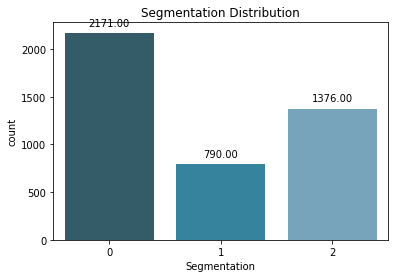

In [54]:
plt.title("Segmentation Distribution")
viz_categorical_summarized(data = df_rfm, x = 'Segmentation', annotate = True)